In [1]:
from tqdm import tqdm
import torch
ch = torch
import poisoning_adversary
import numpy as np
import os
import poison_profiles
from torchvision import transforms
from copy import deepcopy
import poisoned_datasets
import torchvision
from robustness import model_utils, attacker, attack_steps
import gammas
import selection_strategy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn import functional as F

from sklearn.datasets import make_blobs
device = torch.device("cuda:2")

/homes/53/amartya/miniconda3/envs/sneaky/lib/python3.7/site-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


In [3]:
CLASS_SIZE = 2**6
# RESOLUTION = 1000
DIMENSIONS=2
STEP_SIZE=0.01
EPS=0.1
ITERATIONS=60
EPOCHS = 1000
LR = 0.0005

In [7]:
def unzip(l):
    return [i[0] for i in l], [i[1] for i in l]

'''
Dataset
'''
def get_dataset(dist, poison_cnt):
#     DIMENSIONS=784
    std = 0.2
    mean = 0.3
    dist = dist*std
    
    x = np.concatenate([np.random.normal(-1*mean, std, size=[CLASS_SIZE-poison_cnt, DIMENSIONS]),
         np.random.normal(mean, std, size=[CLASS_SIZE-poison_cnt, DIMENSIONS])], axis=0)
    y = [int(i >= len(x)//2) for i, _ in enumerate(x)]
    px = np.random.normal(size=[poison_cnt*2, DIMENSIONS])
    norm = (np.sum(px ** 2, axis=-1) ** 0.5).reshape([-1, 1])
    px = dist * px / norm
    offset = np.asarray([-1*mean for _ in range(poison_cnt)] + [mean for _ in range(poison_cnt)]).reshape([-1, 1])
    if len(offset) >0:
        px = px + offset
        py = [int(i < len(px)//2) for i, _ in enumerate(px)]
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
    train = list(zip(x.astype(np.float32), y))
    
    x = np.concatenate([np.random.normal(-1*mean, std, size=[CLASS_SIZE*10, DIMENSIONS]),
         np.random.normal(mean, std, size=[CLASS_SIZE*10, DIMENSIONS])], axis=0).astype(np.float32)
    y = [int(i >= len(x)//2) for i, _ in enumerate(x)]
    test = list(zip(x, y))
    
    return train, test

def get_dataset(n_flips=0):
    X1, Y1 = make_blobs(CLASS_SIZE, n_features=2, centers=[[-2,0],[2,0]], cluster_std=[[1.5,0.05],[1.5,0.05]])
    label_flips_pos = np.random.permutation(np.random.permutation(np.where(Y1)[0]))[0:n_flips]
    for xx in label_flips_pos:
        Y1[xx] = 1 - Y1[xx]
    label_flips_neg = np.random.permutation(np.random.permutation(np.where(1-Y1)[0]))[0:n_flips]
    for xx in label_flips_neg:
        Y1[xx] = 1 - Y1[xx]
    X2, Y2 = make_blobs(CLASS_SIZE*5, n_features=2, centers=[[-2,0],[2,0]], cluster_std=[[1.5,0.05],[1.5,0.05]])
    train = list(zip(X1.astype(np.float32), Y1))
    test = list(zip(X2.astype(np.float32), Y2))
    
    return train, test, 

In [8]:
from robustness.tools import helpers
from robustness import attack_steps

class LinfStep(attack_steps.AttackerStep):
    """
    Attack step for :math:`\ell_\infty` threat model. Given :math:`x_0`
    and :math:`\epsilon`, the constraint set is given by:
    .. math:: S = \{x | \|x - x_0\|_\infty \leq \epsilon\}
    """
    def project(self, x):
        """
        """
        diff = x - self.orig_input
        diff = ch.clamp(diff, -self.eps, self.eps)
        return self.orig_input + diff

    def step(self, x, g):
        """
        """
        step = ch.sign(g) * self.step_size
        return x + step

    def random_perturb(self, x):
        """
        """
        new_x = x + 2 * (ch.rand_like(x) - 0.5) * self.eps
        return new_x

class Attacker(ch.nn.Module):
    """
    Attacker class, used to make adversarial examples.

    This is primarily an internal class, you probably want to be looking at
    :class:`robustness.attacker.AttackerModel`, which is how models are actually
    served (AttackerModel uses this Attacker class).

    However, the :meth:`robustness.Attacker.forward` function below
    documents the arguments supported for adversarial attacks specifically.
    """
    def __init__(self, model):
        """
        Initialize the Attacker

        Args:
            nn.Module model : the PyTorch model to attack
            Dataset dataset : dataset the model is trained on, only used to get mean and std for normalization
        """
        super(Attacker, self).__init__()
        self.model = model

    def forward(self, x, target, *_, constraint, eps, step_size, iterations,
                random_start=True, random_restarts=False, do_tqdm=False,
                targeted=False, custom_loss=None, should_normalize=False,
                orig_input=None, use_best=True, return_image=True,
                est_grad=None, mixed_precision=False):
        # Can provide a different input to make the feasible set around
        # instead of the initial point
        if orig_input is None: orig_input = x.detach()
        orig_input = orig_input

        # Multiplier for gradient ascent [untargeted] or descent [targeted]
        m = -1 if targeted else 1

        # Initialize step class and attacker criterion
        criterion = ch.nn.CrossEntropyLoss(reduction='none')
        step_class = LinfStep
        step = step_class(eps=eps, orig_input=orig_input, step_size=step_size) 

        def calc_loss(inp, target):
            '''
            Calculates the loss of an input with respect to target labels
            Uses custom loss (if provided) otherwise the criterion
            '''
            if should_normalize:
                inp = self.normalize(inp)
            output = self.model(inp)
            if custom_loss:
                return custom_loss(self.model, inp, target)

            return criterion(output, target), output

        # Main function for making adversarial examples
        def get_adv_examples(x):
#             print('start', x)
            # Random start (to escape certain types of gradient masking)
            if random_start:
                x = step.random_perturb(x)

#             print('random per', x)
            
            iterator = range(iterations)
            if do_tqdm: iterator = tqdm(iterator)

            # Keep track of the "best" (worst-case) loss and its
            # corresponding input
            best_loss = None
            best_x = None

            # A function that updates the best loss and best input
            def replace_best(loss, bloss, x, bx):
                if bloss is None:
                    bx = x.clone().detach()
                    bloss = loss.clone().detach()
                else:
                    replace = m * bloss < m * loss
                    bx[replace] = x[replace].clone().detach()
                    bloss[replace] = loss[replace]

                return bloss, bx

            # PGD iterates
            for _ in iterator:
                x = x.clone().detach().requires_grad_(True)
                losses, out = calc_loss(step.to_image(x), target)
                assert losses.shape[0] == x.shape[0], \
                        'Shape of losses must match input!'

                loss = ch.mean(losses)

                if step.use_grad:
                    if (est_grad is None) and mixed_precision:
                        with amp.scale_loss(loss, []) as sl:
                            sl.backward()
                        grad = x.grad.detach()
                        x.grad.zero_()
                    elif (est_grad is None):
                        grad, = ch.autograd.grad(m * loss, [x])
                    else:
                        f = lambda _x, _y: m * calc_loss(step.to_image(_x), _y)[0]
                        grad = helpers.calc_est_grad(f, x, target, *est_grad)
                else:
                    grad = None

                with ch.no_grad():
                    args = [losses, best_loss, x, best_x]
                    best_loss, best_x = replace_best(*args) if use_best else (losses, x)

                    x = step.step(x, grad)
                    x = step.project(x)
                    if do_tqdm: iterator.set_description("Current loss: {l}".format(l=loss))

            # Save computation (don't compute last loss) if not use_best
            if not use_best: 
                ret = x.clone().detach()
                return step.to_image(ret) if return_image else ret

            losses, _ = calc_loss(step.to_image(x), target)
            args = [losses, best_loss, x, best_x]
            best_loss, best_x = replace_best(*args)
            return step.to_image(best_x) if return_image else best_x

        # Random restarts: repeat the attack and find the worst-case
        # example for each input in the batch
        if random_restarts:
            to_ret = None

            orig_cpy = x.clone().detach()
            for _ in range(random_restarts):
                adv = get_adv_examples(orig_cpy)

                if to_ret is None:
                    to_ret = adv.detach()

                _, output = calc_loss(adv, target)
                corr, = helpers.accuracy(output, target, topk=(1,), exact=True)
                corr = corr.byte()
                misclass = ~corr
                to_ret[misclass] = adv[misclass]

            adv_ret = to_ret
        else:
            adv_ret = get_adv_examples(x)

        return adv_ret

class AttackerModel(ch.nn.Module):
    def __init__(self, model):
        super(AttackerModel, self).__init__()
#         self.normalizer = helpers.InputNormalize(dataset.mean, dataset.std)
        self.model = model
        self.attacker = Attacker(model)

    def forward(self, inp, target=None, make_adv=True,
                with_image=True, **attacker_kwargs):
        
        if make_adv:
            assert target is not None
            prev_training = bool(self.training)
            self.eval()
            adv = self.attacker(inp, target, **attacker_kwargs)
            if prev_training:
                self.train()

            inp = adv

        normalized_inp = inp

        output = self.model(normalized_inp)
        if with_image:
            return (output, inp)
        return output

In [9]:

def get_model(units=1024, inputs=DIMENSIONS):
    return torch.nn.Sequential(
            torch.nn.Linear(inputs, units),
#             torch.nn.BatchNorm1d(num_features=units, momentum=0.99),
            torch.nn.ReLU(),
            torch.nn.Linear(units, 2*units),
#             torch.nn.BatchNorm1d(num_features=units, momentum=0.99),
            torch.nn.ReLU(),
            torch.nn.Linear(2*units, 4*units),
#             torch.nn.BatchNorm1d(num_features=2*units, momentum=0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(4*units, 2*units),
#             torch.nn.BatchNorm1d(num_features=units, momentum=0.99),
            torch.nn.ReLU(),
            torch.nn.Linear(2*units, 2)
        )


def test(amodel, data_loader):
    results = []
    amodel.eval()
    for x, y in data_loader:
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            output = torch.argmax(amodel(x), dim=-1)
        results.extend((output.view(-1) == y).detach().cpu().numpy())
    amodel.train()
    return results.count(True) / len(results)

def adv(model, data_loader):
    amodel = AttackerModel(model)
    res = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        _, input = amodel(x, y, make_adv=True,
             constraint='inf', step_size=STEP_SIZE,
             eps=EPS, iterations=ITERATIONS, random_restarts=1,
                      targeted=False)
#         print(input)
        out = model(input)
        out = torch.argmax(out, dim=-1) == y
        res.extend(out.detach().cpu().numpy())
#     print(res)
    return res.count(True) / len(res)

def train(model, data_loader, test_loader):
    epochs=EPOCHS
    lr=LR
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=lr,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=90, gamma=0.1)
    loss = torch.nn.CrossEntropyLoss()
    loss_log = []
    test_log = [test(model, data_loader)]
    for epoch in range(epochs):
        loss_avg = 0.0
        model.train()
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss_val = loss(output, target=y)
            loss_avg = loss_avg * 0.5 + 0.5 * loss_val.detach().cpu().numpy()
            loss_val.backward()
            optimizer.step()
        scheduler.step()
        test_log.append(test(model, data_loader))
        loss_log.append(loss_avg)
    
    return loss_log, test_log, test(model, test_loader), adv(model, test_loader), test(model, data_loader)

In [10]:
def get_vulnerable_mask(model, dataset):
    '''
    Returns a boolean list over datapoints, specifying which ones are 
    vulnerable (True) and which ones are not (False)
    '''
    amodel = AttackerModel(model)
    res = []
    adv_lbl = []
    orig = []
    for x, y in tqdm(dataset):
        x, y = x.to(device), y.to(device)
        out, input = amodel(x, y, make_adv=True,
             constraint='inf', step_size=STEP_SIZE,
             eps=EPS, iterations=ITERATIONS, random_restarts=8,
                      targeted=False)
        out_correct = torch.argmax(out, dim=-1) == y
        for idx, oo_ in enumerate(out_correct):
            if oo_ <1:
                with torch.no_grad():
                    if torch.argmax(model(x[idx].unsqueeze(0)), dim=-1)[0] == y[idx]:
                        res.append(input[idx].cpu().detach().numpy())
                        orig.append(x[idx].cpu().detach().numpy())
                        adv_lbl.append(torch.argmax(out[idx], dim=-1).cpu().detach().numpy())
    return res, orig,  adv_lbl

In [11]:
# plt.plot(train_acc, label='train accuracy', c='b')
# print('Test Acc: {}, Adv Acc: {}'.format(test_acc, adv_acc))
# plt.plot(loss, label='loss', c='r')
# plt.grid()
# plt.legend()
# plt.show()

In [12]:
def run(seed, lbl_flip=0, return_net=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    model = get_model(1024).to(device)
    train_, test_,  = get_dataset(lbl_flip)
    train_ = torch.utils.data.DataLoader(train_, batch_size=32)
#     print(train)
    test_ = torch.utils.data.DataLoader(test_, batch_size=512)
    loss,  test_loss, test_acc, adv_acc, train_acc = train(model, train_, test_)
    if return_net is False:
        return loss, test_acc, adv_acc, train_acc 
    else:
        return loss, test_acc, adv_acc, train_acc,  model, test_, train_
    

In [13]:
seed=0
loss, test_acc, adv_acc, train_acc,  model, test_, train_ = run(seed,0 , True)


/homes/53/amartya/miniconda3/envs/sneaky/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/IndexingUtils.h:30.)


In [14]:
test_acc, train_acc, adv_acc

(0.890625, 0.96875, 0.684375)

In [15]:
vul_exs, vul_orig_exs, vul_lbls = get_vulnerable_mask(model, test_)


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


100%|██████████| 1954/1954 [00:03<00:00, 494.41it/s]
/homes/53/amartya/miniconda3/envs/sneaky/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


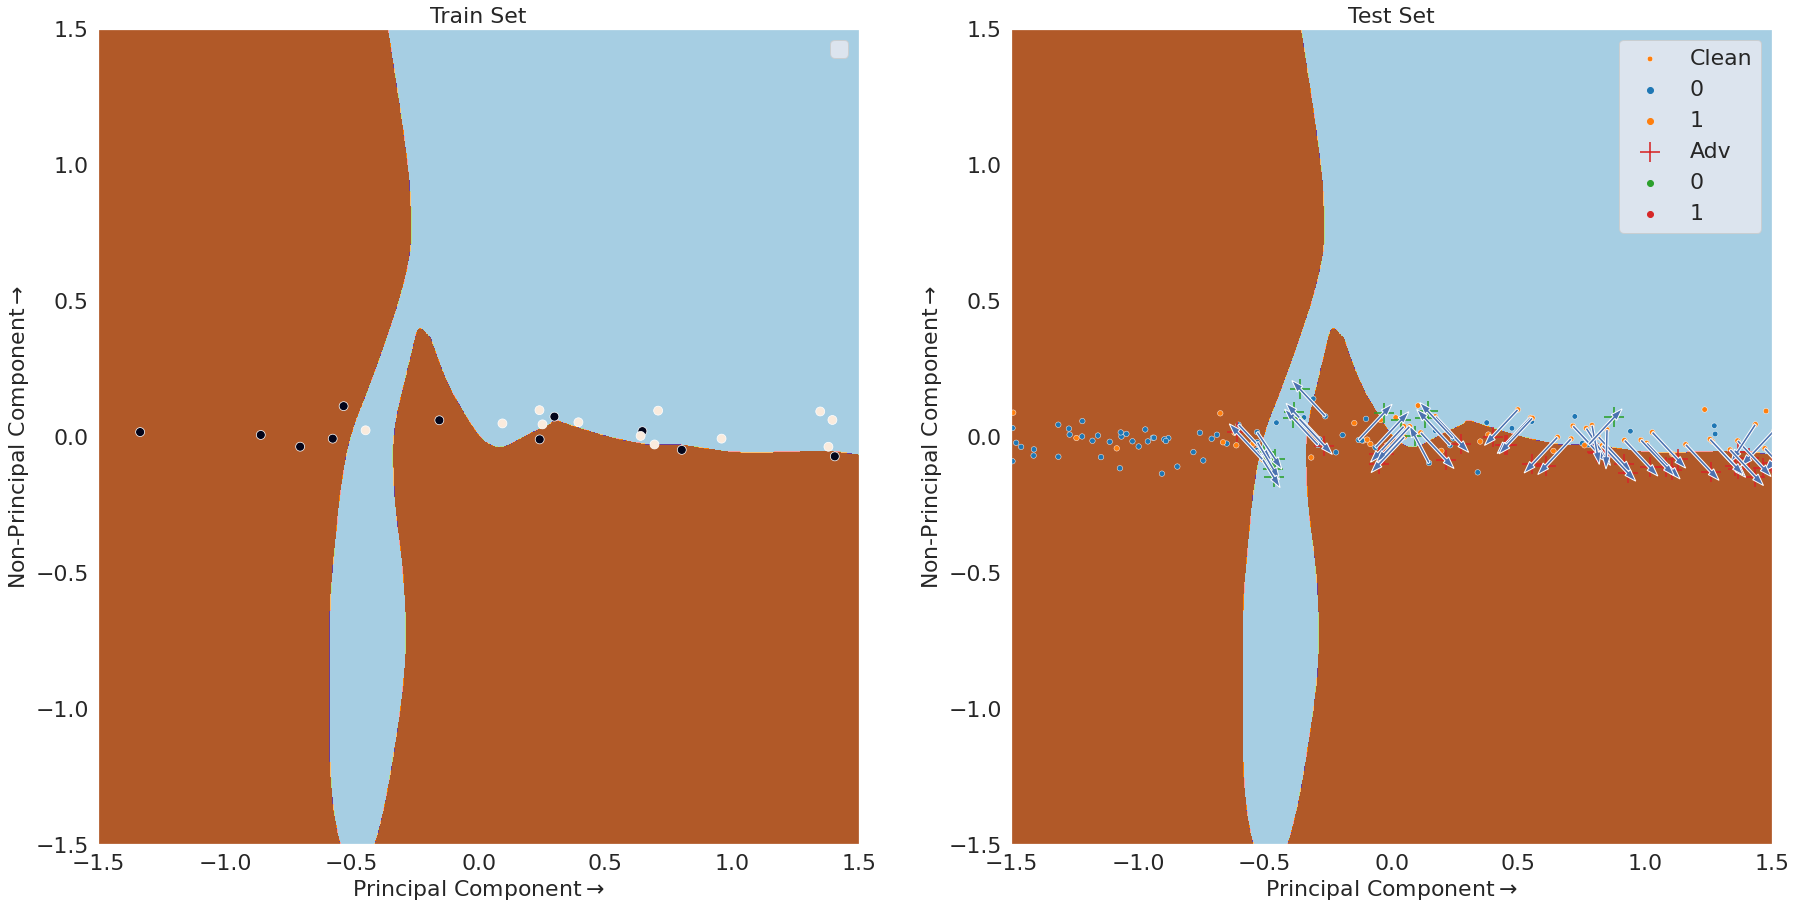

In [29]:
import seaborn
from matplotlib import patches
xaxis = np.linspace(-1.5, 1.5, 1000).astype(np.float32)
yaxis = np.linspace(-1.5, 1.5, 1000).astype(np.float32)
xx,yy = np.meshgrid(xaxis, yaxis)
seaborn.set()
model.eval()
fig,axes=plt.subplots(1,2, figsize=(30,15))
# cp = ax.contourf(xx,yy,z.reshape(xx.shape))
cntr_dataset = list(np.c_[xx.ravel(), yy.ravel()])
bs_ = 512
cntr_loader = torch.utils.data.DataLoader(cntr_dataset, batch_size=bs_, shuffle=False)
Z=np.empty(len(cntr_dataset))
enum_idx = 0
for xx_ in tqdm(cntr_loader):
    with torch.no_grad():
        Z[enum_idx*bs_:enum_idx*bs_+len(xx_)] = (torch.softmax(model(xx_.to(device)), dim=1)[:,0]).detach().cpu().numpy()>0.5
    enum_idx += 1
# with torch.no_grad():
#     Z = torch.softmax(model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)), dim=1)[:,0].detach().cpu().numpy()>=0.5

# Put the result into a color plot
Z = np.asarray(Z).reshape(xx.shape)
cp=axes[0].contourf(xx, yy, Z, cmap=plt.cm.Paired)
cp=axes[1].contourf(xx, yy, Z, cmap=plt.cm.Paired)


seaborn.scatterplot(x=[xx[0] for xx,_ in train_.dataset[:]], y=[xx[1] for xx,_ in train_.dataset[:]], 
            c=[xx for _,xx in train_.dataset[:]], ax=axes[0], s=80, palette=seaborn.color_palette('tab10')[0:2])


seaborn.scatterplot(x=[xx[0] for xx,_ in test_.dataset[:]], y=[xx[1] for xx,_ in test_.dataset[:]], 
            hue=[xx for _,xx in test_.dataset[:]], ax=axes[1], s=30, palette=seaborn.color_palette('tab10')[0:2], label="Clean")

seaborn.scatterplot(np.asarray(vul_exs)[:,0],np.asarray(vul_exs)[:,1], hue= (1-np.asarray(vul_lbls)), 
                    marker='+', s=400,  ax=axes[1], palette=seaborn.color_palette('tab10')[2:4], label="Adv")

# seaborn.scatterplot(np.asarray(vul_orig_exs)[:,0],np.asarray(vul_orig_exs)[:,1], hue= (1-np.asarray(vul_lbls))+2, marker='x', 
#                     s=60,  ax=axes[1], palette=seaborn.color_palette('tab10')[2:4])

for exs in zip(vul_orig_exs, vul_exs):

    arr = patches.FancyArrow(exs[0][0], exs[0][1], exs[1][0]-exs[0][0], exs[1][1]-exs[0][1], width=0.01, #head_length=0.05, head_width=0.1, 
                             shape='full', length_includes_head=False)
    axes[1].add_patch(arr)
#     ax.annotate("", xytext=(exs[0][0], exs[0][1]), xy=(exs[1][0]-exs[0][0], exs[1][0]-exs[0][0]),
#             arrowprops=dict(arrowstyle="->, head_length = 0, head_width = .5", lw=1))

# pca.components_
for ax in axes:
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_xlabel("Principal Component"+ r'$\rightarrow$', fontsize=22)
    ax.set_ylabel("Non-Principal Component"+ r'$\rightarrow$', fontsize=22)
    ax.legend(fontsize=22)
    axes[1].set_title('Test Set', fontsize=22)
    axes[0].set_title('Train Set', fontsize=22)
#     arr = patches.FancyArrow(-2.5, -0.2, -pca.components_[0][0], -pca.components_[0][1], width=0.01, #head_length=0.05, head_width=0.1, 
#                              shape='full', length_includes_head=False)
#     ax.add_patch(arr)
#     arr = patches.FancyArrow(-2.5, -0.2, -pca.components_[1][0], -pca.components_[1][1], width=0.005, #head_length=0.05, head_width=0.1, 
#                              shape='full', length_includes_head=False)
#     ax.add_patch(arr)
#     ax.set_xticklabels(x_ticks, rotation=0, fontsize=22)
#     ax.set_yticklabels(y_ticks, rotation=0, fontsize=22)
#     ax.axis("off")
plt.savefig('adv_2d_subspace_noiseless.svg')
# fig.colorbar(cp) # Add a colorbar to a plot

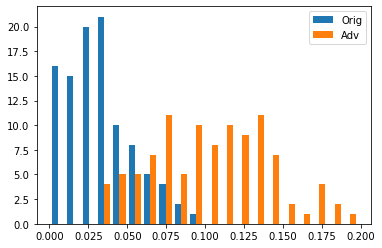

In [834]:
plt.hist(bins=20, x=[[abs(x) for x in unzip(vul_orig_exs)[1]], [abs(x) for x in unzip(vul_exs)[1]]], label=['Orig', 'Adv'])
plt.legend()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]